In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("dataset.csv")

# EDA and Verification

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
print(df.head())

        Date      Product_Name   Category  Cost_Price  Selling_Price  \
0 2025-07-01     Water Bottles  Beverages        0.85           1.00   
1 2025-07-01       Soft Drinks  Beverages        0.90           1.25   
2 2025-07-01     Energy Drinks  Beverages        1.50           2.50   
3 2025-07-01  Cheap Chocolates     Snacks        0.40           1.00   
4 2025-07-01              Gums     Snacks        0.30           1.25   

   Inventory_Start  Restock_Received  Units_Sold  Inventory_End  \
0               45                40          70             15   
1               60                 0          35             25   
2               30                20          15             35   
3              100                 0          12             88   
4              150                 0           8            142   

   Is_Promotion_Active  
0                 True  
1                 True  
2                False  
3                False  
4                False  


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3680 entries, 0 to 3679
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 3680 non-null   datetime64[ns]
 1   Product_Name         3680 non-null   object        
 2   Category             3680 non-null   object        
 3   Cost_Price           3680 non-null   float64       
 4   Selling_Price        3680 non-null   float64       
 5   Inventory_Start      3680 non-null   int64         
 6   Restock_Received     3680 non-null   int64         
 7   Units_Sold           3680 non-null   int64         
 8   Inventory_End        3680 non-null   int64         
 9   Is_Promotion_Active  3680 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 262.5+ KB
None


In [10]:
unique_products = df['Product_Name'].unique()
num_products = len(unique_products)
print(f"Count of Unique Products: {num_products}")
print(f"Product List:\n{'\n'.join(sorted(unique_products))}")

Count of Unique Products: 20
Product List:
AA Batteries
Aluminum Foil
Canned Tuna
Cheap Chocolates
Cleaning Spray
Disposable Plates
Dog Treats
Energy Drinks
Garbage Bags
Gums
Hand Soap
Napkins
Notebooks
Pads
Pens
Seasonal Decor
Soft Drinks
Sponges
Superglue
Water Bottles


In [11]:
price_stats = df[['Cost_Price', 'Selling_Price']].describe()
print(price_stats)

        Cost_Price  Selling_Price
count  3680.000000    3680.000000
mean      1.227500       2.674500
std       0.722503       1.396007
min       0.300000       1.000000
25%       0.725000       1.500000
50%       1.000000       2.500000
75%       1.575000       3.250000
max       3.000000       5.500000


In [12]:
start_date = df['Date'].min().strftime('%Y-%m-%d')
end_date = df['Date'].max().strftime('%Y-%m-%d')
total_days = (df['Date'].max() - df['Date'].min()).days + 1

print(f"Start Date: {start_date}")
print(f"End Date:   {end_date}")
print(f"Total Duration: {total_days} Days")

Start Date: 2025-07-01
End Date:   2025-12-31
Total Duration: 184 Days


# Analysis

### Setup

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Calculation Columns
df['DayOfWeek'] = df['Date'].dt.day_name()
df['Unit_Margin'] = df['Selling_Price'] - df['Cost_Price']
df['Daily_Total_Profit'] = df['Units_Sold'] * df['Unit_Margin']

# CHECK
df[['Date', 'Product_Name', 'Unit_Margin', 'Daily_Total_Profit']].head()

,Date,Product_Name,Unit_Margin,Daily_Total_Profit
0,2025-07-01,Water Bottles,0.15,10.50
1,2025-07-01,Soft Drinks,0.35,12.25
2,2025-07-01,Energy Drinks,1.00,15.00
3,2025-07-01,Cheap Chocolates,0.60,7.20
4,2025-07-01,Gums,0.95,7.60


### 1. Profit Loss (On Stockout Days)

#### With Seasonal

/var/folders/yv/m8m094415gv4fqnyvhvpl6lh0000gn/T/ipykernel_28278/443278417.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lost_profit_summary.head(10), x='Estimated_Lost_Profit', y='Product_Name', palette="magma")


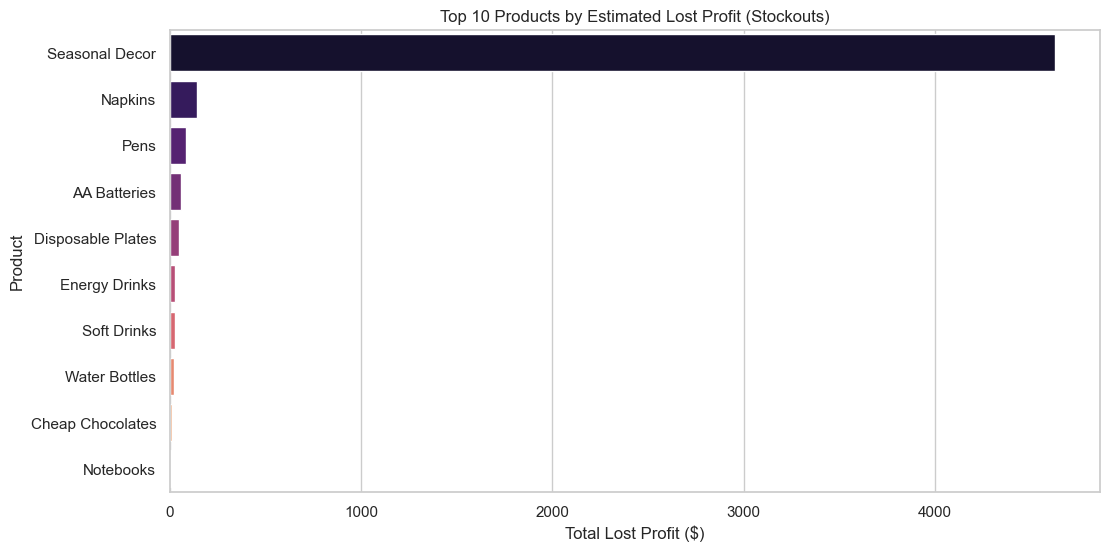

,Product_Name,Estimated_Lost_Profit
0,Seasonal Decor,4627.804170
1,Napkins,146.145808
2,Pens,86.247308
3,AA Batteries,59.689738
4,Disposable Plates,48.718754
5,Energy Drinks,29.120614
6,Soft Drinks,27.018627
7,Water Bottles,25.240169
8,Cheap Chocolates,14.040000
9,Notebooks,8.960000


In [18]:
stockout_days = df[df['Inventory_End'] == 0].copy()

def calculate_loss(row):
    same_day_stats = df[
        (df['Product_Name'] == row['Product_Name']) & 
        (df['DayOfWeek'] == row['DayOfWeek']) & 
        (df['Inventory_End'] > 0)
    ]
    
    avg_demand = same_day_stats['Units_Sold'].mean() if not same_day_stats.empty else row['Units_Sold']
    
    missed_units = max(0, avg_demand - row['Units_Sold'])
    return missed_units * row['Unit_Margin']

stockout_days['Estimated_Lost_Profit'] = stockout_days.apply(calculate_loss, axis=1)

lost_profit_summary = stockout_days.groupby('Product_Name')['Estimated_Lost_Profit'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=lost_profit_summary.head(10), x='Estimated_Lost_Profit', y='Product_Name', palette="magma")
plt.title('Top 10 Products by Estimated Lost Profit (Stockouts)')
plt.xlabel('Total Lost Profit ($)')
plt.ylabel('Product')
plt.show()

lost_profit_summary.head(10)

#### Without Seasonal

/var/folders/yv/m8m094415gv4fqnyvhvpl6lh0000gn/T/ipykernel_28278/842122680.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lost_profit_summary.head(10), x='Estimated_Lost_Profit', y='Product_Name', palette="magma")


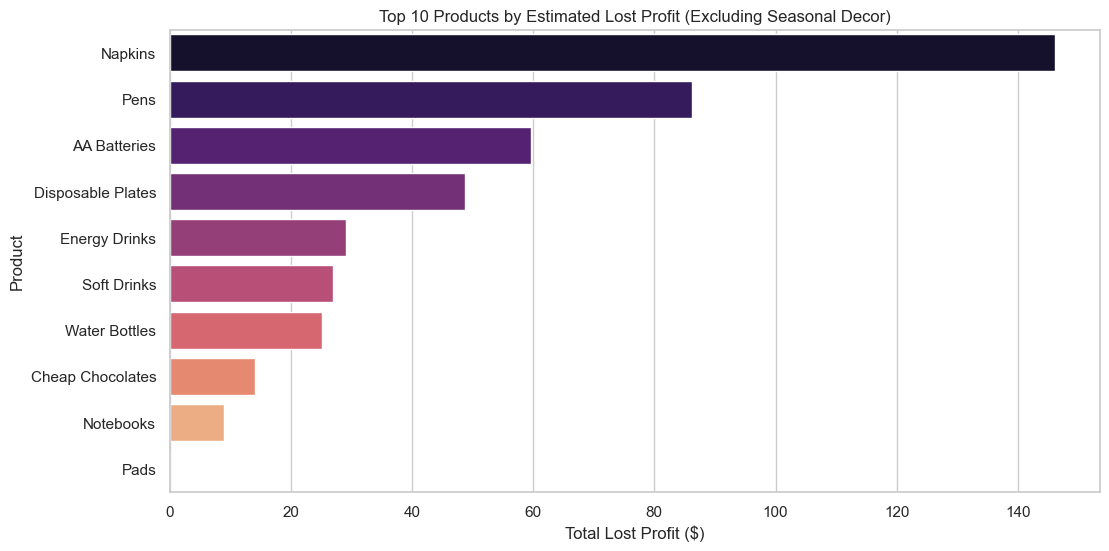

,Product_Name,Estimated_Lost_Profit
0,Napkins,146.145808
1,Pens,86.247308
2,AA Batteries,59.689738
3,Disposable Plates,48.718754
4,Energy Drinks,29.120614
5,Soft Drinks,27.018627
6,Water Bottles,25.240169
7,Cheap Chocolates,14.040000
8,Notebooks,8.960000
9,Pads,0.000000


In [19]:
stockout_days = df[df['Inventory_End'] == 0].copy()

def calculate_loss(row):
    same_day_stats = df[
        (df['Product_Name'] == row['Product_Name']) & 
        (df['DayOfWeek'] == row['DayOfWeek']) & 
        (df['Inventory_End'] > 0)
    ]
    
    avg_demand = same_day_stats['Units_Sold'].mean() if not same_day_stats.empty else row['Units_Sold']
    
    missed_units = max(0, avg_demand - row['Units_Sold'])
    return missed_units * row['Unit_Margin']

stockout_days['Estimated_Lost_Profit'] = stockout_days.apply(calculate_loss, axis=1)

lost_profit_summary = stockout_days[stockout_days['Product_Name'] != 'Seasonal Decor'].groupby('Product_Name')['Estimated_Lost_Profit'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=lost_profit_summary.head(10), x='Estimated_Lost_Profit', y='Product_Name', palette="magma")
plt.title('Top 10 Products by Estimated Lost Profit (Excluding Seasonal Decor)')
plt.xlabel('Total Lost Profit ($)')
plt.ylabel('Product')
plt.show()

lost_profit_summary.head(10)

### 2. Highest Stockout Days

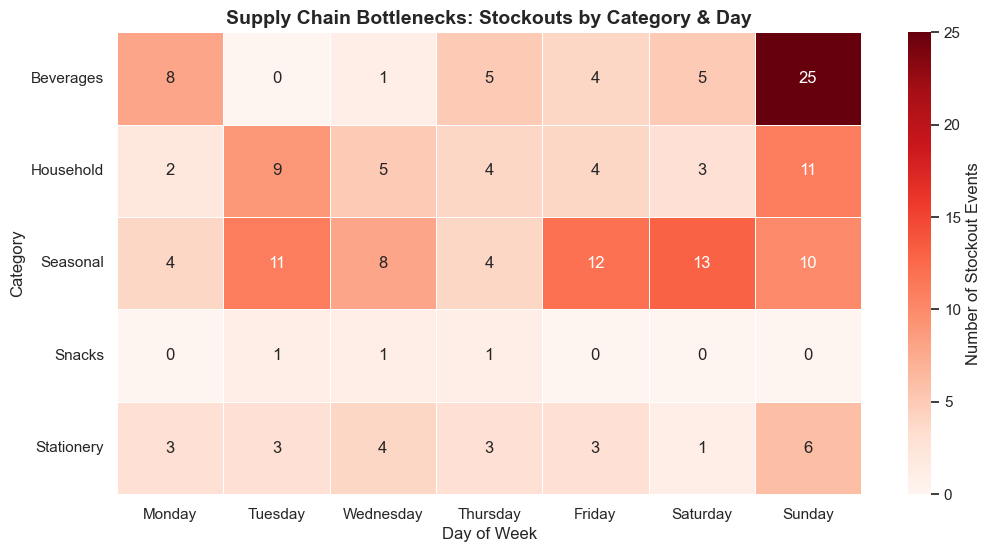

DayOfWeek,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Category,,,,,,,
Beverages,8.0,0.0,1.0,5.0,4.0,5.0,25.0
Household,2.0,9.0,5.0,4.0,4.0,3.0,11.0
Seasonal,4.0,11.0,8.0,4.0,12.0,13.0,10.0
Snacks,0.0,1.0,1.0,1.0,0.0,0.0,0.0
Stationery,3.0,3.0,4.0,3.0,3.0,1.0,6.0


In [25]:
stockout_counts = stockout_days.groupby(['Category', 'DayOfWeek']).size().reset_index(name='Stockout_Count')

stockout_matrix = stockout_counts.pivot(index='Category', columns='DayOfWeek', values='Stockout_Count')

week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
stockout_matrix = stockout_matrix.reindex(columns=week_order).fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(stockout_matrix, annot=True, fmt='g', cmap="Reds", linewidths=0.5, cbar_kws={'label': 'Number of Stockout Events'})

plt.title('Supply Chain Bottlenecks: Stockouts by Category & Day', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.yticks(rotation=0) 
plt.show()

display(stockout_matrix) 

### Promotional Effectiveness

/opt/miniconda3/envs/Data-Analysis/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/Data-Analysis/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/Data-Analysis/lib/python3.14/site-packages/matplotlib/transforms.py:352: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]


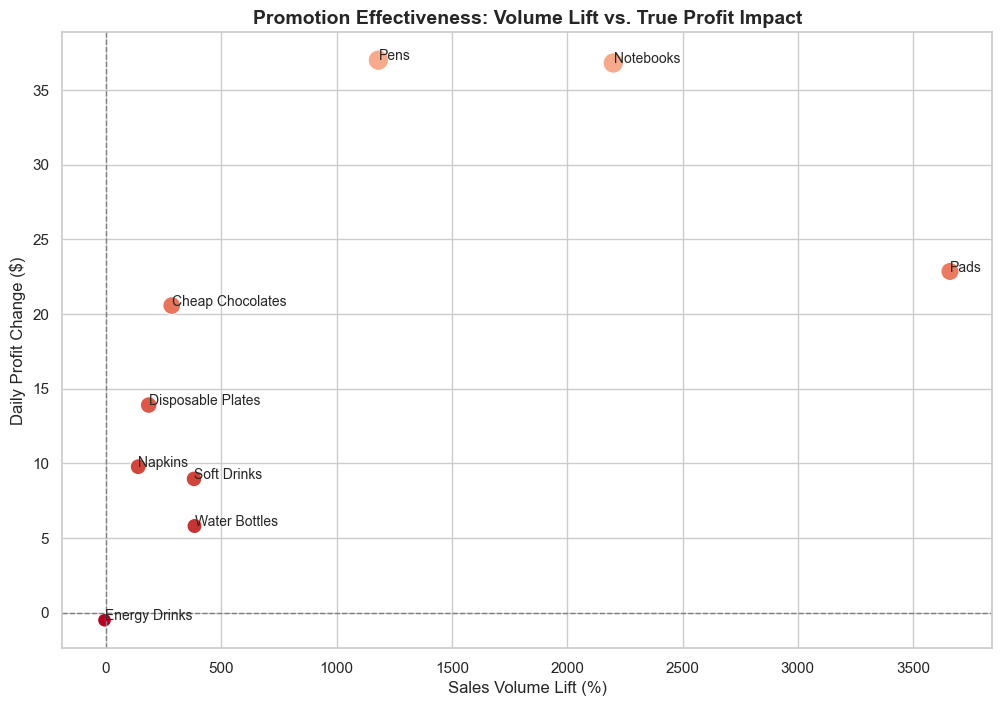

,Volume_Lift_Pct,Profit_Impact_Daily
Product_Name,,
Energy Drinks,-6.111863,-0.499079
Water Bottles,384.087309,5.806623
Soft Drinks,381.949153,8.962784
Napkins,139.682540,9.777778
Disposable Plates,185.414365,13.906077


In [26]:
promo_stats = df.groupby(['Product_Name', 'Is_Promotion_Active']).agg({
    'Units_Sold': 'mean',
    'Daily_Total_Profit': 'mean'
}).unstack()

promo_stats.columns = ['Vol_Normal', 'Vol_Promo', 'Profit_Normal', 'Profit_Promo']
promo_stats = promo_stats.dropna() 

promo_stats['Volume_Lift_Pct'] = ((promo_stats['Vol_Promo'] - promo_stats['Vol_Normal']) / promo_stats['Vol_Normal']) * 100

promo_stats['Profit_Impact_Daily'] = promo_stats['Profit_Promo'] - promo_stats['Profit_Normal']

plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=promo_stats, 
    x='Volume_Lift_Pct', 
    y='Profit_Impact_Daily', 
    size='Profit_Impact_Daily', 
    sizes=(100, 500), 
    hue='Profit_Impact_Daily', 
    palette="coolwarm_r",
    legend=False
)

plt.axhline(0, color='grey', linestyle='--', linewidth=1) # Profit Line
plt.axvline(0, color='grey', linestyle='--', linewidth=1) # Volume Line

plt.text(x=promo_stats['Volume_Lift_Pct'].max()*0.8, y=promo_stats['Profit_Impact_Daily'].max()*0.8, s="✅ PROFITABLE WINS", color='green', fontweight='bold')
plt.text(x=promo_stats['Volume_Lift_Pct'].max()*0.8, y=promo_stats['Profit_Impact_Daily'].min()*0.8, s="❌ EMPTY CALORIES", color='red', fontweight='bold')

for product, row in promo_stats.iterrows():
    plt.text(row['Volume_Lift_Pct']+1, row['Profit_Impact_Daily'], product, fontsize=10)

plt.title('Promotion Effectiveness: Volume Lift vs. True Profit Impact', fontsize=14, fontweight='bold')
plt.xlabel('Sales Volume Lift (%)', fontsize=12)
plt.ylabel('Daily Profit Change ($)', fontsize=12)
plt.show()

display(promo_stats.sort_values('Profit_Impact_Daily').head(5)[['Volume_Lift_Pct', 'Profit_Impact_Daily']])